Good afternoon sir,
During this notebook we will try to use all the techniques we saw in CDA so far. 
We will then compare them to select the best model ! 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, PowerTransformer
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
df = pd.read_csv('car data.csv')

Let's clean first the outliers

In [33]:
num_cols = ['Selling_Price','Present_Price','Kms_Driven']
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
mask = ~((df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)
df = df[mask].reset_index(drop=True)

Let's visualize a bit this data. 

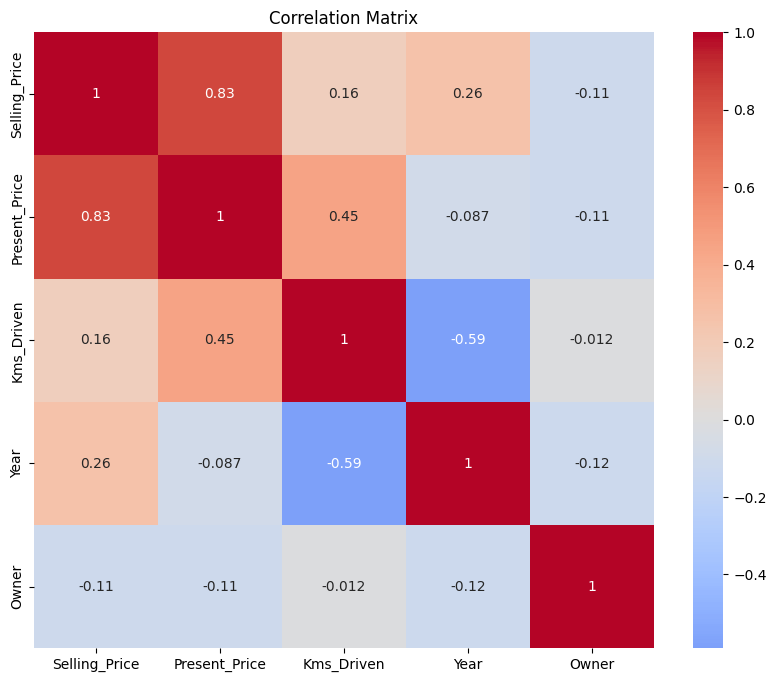

In [34]:
numerical_cols = ['Selling_Price', 'Present_Price', 'Kms_Driven', 'Year', 'Owner']
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

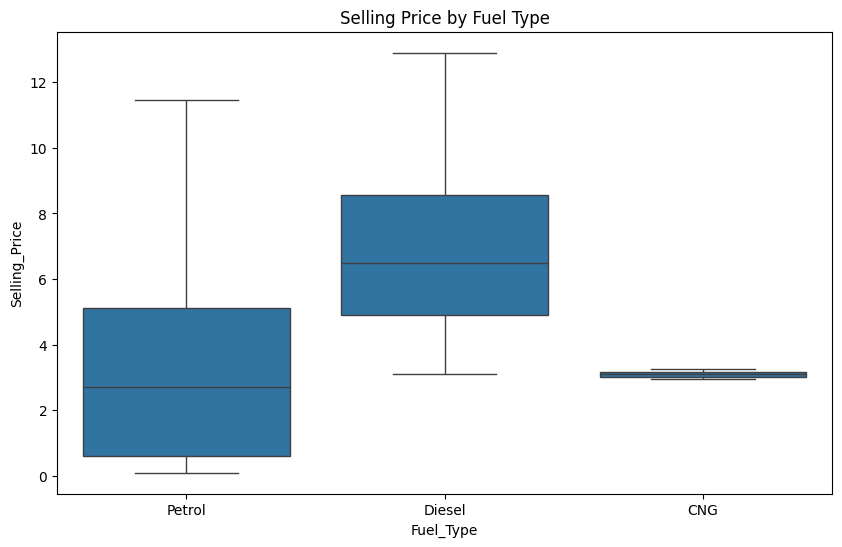

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fuel_Type', y='Selling_Price', data=df)
plt.title('Selling Price by Fuel Type')
plt.show()

Let's make also some feature engineering.

In [36]:
df['Age'] = 2025 - df['Year']
df['Kms_per_Year'] = df['Kms_Driven'] / (df['Age'].replace(0,1))
df = df.drop(['Car_Name','Year','Kms_Driven','Owner'], axis=1)

In [37]:
df.head(13)

,Selling_Price,Present_Price,Fuel_Type,Seller_Type,Transmission,Age,Kms_per_Year
0,3.35,5.59,Petrol,Dealer,Manual,11,2454.545455
1,4.75,9.54,Diesel,Dealer,Manual,12,3583.333333
2,7.25,9.85,Petrol,Dealer,Manual,8,862.500000
3,2.85,4.15,Petrol,Dealer,Manual,14,371.428571
4,4.60,6.87,Diesel,Dealer,Manual,11,3859.090909
5,9.25,9.83,Diesel,Dealer,Manual,7,295.857143
6,6.75,8.12,Petrol,Dealer,Manual,10,1879.600000
7,6.50,8.61,Diesel,Dealer,Manual,10,3342.900000
8,8.75,8.89,Diesel,Dealer,Manual,9,2252.555556
9,7.45,8.92,Diesel,Dealer,Manual,10,4236.700000


let's begin by perform a simple linear regression, 
we will get into more complexity later on

In [ ]:
X = df[['Present_Price']] # As mentionned in the instructions
y = df['Selling_Price']

In [39]:
model = LinearRegression()
model.fit(X, y)


y_pred = model.predict(X)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)


In [40]:
print(f"Intercept: {model.intercept_:.4f}")
print(f"Coefficient: {model.coef_[0]:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

Intercept: 0.6325
Coefficient: 0.5102
Mean Squared Error: 2.8588
R-squared: 0.6932


We should then perform : Imputation, Encoding & Scaling

In [41]:
numeric_feats = ['Present_Price','Age','Kms_per_Year']
categorical_feats = ['Fuel_Type','Seller_Type','Transmission']

numeric_transformer = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('power', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_feats),
    ('cat', categorical_transformer, categorical_feats)
])


Let's split the data (train and test) as we saw in class

In [42]:
X = df.drop('Selling_Price', axis=1)
y = df['Selling_Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Let's model the pipeline 

In [43]:
reduction = Pipeline([
    ('pre', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('select', SelectKBest(score_func=f_regression, k=10)),
    ('pca', PCA(n_components=5))
])

model = Pipeline([
    ('reduce', reduction),
    ('reg', RandomForestRegressor(n_estimators=100, max_depth=7, random_state=42))
])

model.fit(X_train, y_train)
pred = model.predict(X_test)

Let's evaluate the model !

In [44]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred)))
print('R2:', r2_score(y_test, pred))

cv = cross_val_score(model, X, y, cv=KFold(5, shuffle=True, random_state=42), scoring='neg_mean_squared_error')
print('CV RMSE:', np.sqrt(-cv).mean())

RMSE: 1.4384736459665188
R2: 0.8082310033935561
CV RMSE: 1.2843126107985525


The model explains about 81% of the variance in prices (R² ≈ 0.81), indicating strong predictive power. The out‐of‐sample RMSE (~1.28) being slightly lower than the test RMSE (~1.44) suggests consistent performance with only modest overfitting.

Let's try to make a better one ! 

In [46]:
gbm = Pipeline([
    ('reduce', reduction),
    ('reg', LGBMRegressor(objective='regression', random_state=42))
])

let's create a more sophisticated pipeline 

In [47]:
param_dist = {
    'reg__n_estimators': [100, 300, 500],
    'reg__max_depth': [4, 6, 8, -1],
    'reg__num_leaves': [15, 31, 63],
    'reg__learning_rate': [0.01, 0.05, 0.1],
    'reg__subsample': [0.6, 0.8, 1.0],
    'reg__colsample_bytree': [0.6, 0.8, 1.0]
} #we should just iterate to find the best params as possible

The output was Best params: {'reg__subsample': 0.6, 'reg__num_leaves': 31, 'reg__n_estimators': 100, 'reg__max_depth': 4, 'reg__learning_rate': 0.1, 'reg__colsample_bytree': 1.0}

In [48]:

search = RandomizedSearchCV(
    gbm,
    param_distributions=param_dist,
    n_iter=25,
    cv=KFold(5, shuffle=True, random_state=42),
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

Let's fit the search, so that we have the best parameters for our model !

In [49]:
search.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 295
[LightGBM] [Info] Number of data points in the train set: 222, number of used features: 5
[LightGBM] [Info] Start training from score 3.730225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('reduce',
                                              Pipeline(steps=[('pre',
                                                               ColumnTransformer(transformers=[('num',
                                                                                                Pipeline(steps=[('imputer',
                                                                                                                 KNNImputer()),
                                                                                                                ('power',
                                                                                                                 PowerTransformer()),
                                                                                                                ('scaler',
                                                                                                                 StandardScaler())]),
                                                                                                ['Present_Price',
                                                                                                 'Age',
                                                                                                 'Kms_per_Year']),
                                                                                               ('cat',
                                                                                                Pipeline(steps=[('onehot',
                                                                                                                 OneHotEnco...
                                              LGBMRegressor(objective='regression',
                                                            random_state=42))]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'reg__colsample_bytree': [0.6, 0.8,
                                                                  1.0],
                                        'reg__learning_rate': [0.01, 0.05, 0.1],
                                        'reg__max_depth': [4, 6, 8, -1],
                                        'reg__n_estimators': [100, 300, 500],
                                        'reg__num_leaves': [15, 31, 63],
                                        'reg__subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [50]:
print("Best params:", search.best_params_)
best = search.best_estimator_
pred = best.predict(X_test)

Best params: {'reg__subsample': 0.6, 'reg__num_leaves': 31, 'reg__n_estimators': 100, 'reg__max_depth': 4, 'reg__learning_rate': 0.1, 'reg__colsample_bytree': 1.0}


c:\bts\CDA\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


**NOW LET'S MAKE THE BEST MODEL POSSIBLE ACCORDING TO THE OPTIMAL PARAMETERS**

In [51]:
params = {
    'n_estimators': 100,
    'max_depth': 4,
    'num_leaves': 31,
    'learning_rate': 0.1,
    'subsample': 0.6,
    'colsample_bytree': 1.0,
    'objective': 'regression',
    'random_state': 42
}

In [52]:
gbm = Pipeline([
    ('reduce', reduction),
    ('reg', LGBMRegressor(**params))
])

In [53]:
gbm.fit(X_train, y_train)
pred = gbm.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 295
[LightGBM] [Info] Number of data points in the train set: 222, number of used features: 5
[LightGBM] [Info] Start training from score 3.730225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

c:\bts\CDA\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [54]:
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, pred)))
print('Test R²:', r2_score(y_test, pred))

Test RMSE: 1.4825725632901325
Test R²: 0.7962927461962088


Let's try an other model, using the techniques saw in class such as SVR and Random Forest

In [55]:
estimators = [
    ('ridge', Ridge(alpha=1)),
    ('svr', SVR(kernel='rbf', C=10, epsilon=0.2)),
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=7, random_state=42))
]

stack = Pipeline([
    ('reduce', reduction),
    ('stack', StackingRegressor(
        estimators=estimators,
        final_estimator=Ridge(alpha=1),
        cv=5,
        n_jobs=-1
    ))
])

In [56]:
stack.fit(X_train, y_train)
pred = stack.predict(X_test)

In [57]:
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, pred)))
print('Test R²:', r2_score(y_test, pred))

Test RMSE: 1.4020144256880263
Test R²: 0.8178288747127143


Ok, not bad, but maybe we can try to create a super learner. By building a diverse pool of strong base models. With Build a diverse pool of strong base models as Gradients. 
a SVR alsofor the Kernel Method. 


In [58]:
base_models = [
    ('lgbm', LGBMRegressor(n_estimators=300, max_depth=6, learning_rate=0.05, random_state=42)),
    ('xgb',  XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.05, verbosity=0, random_state=42)),
    ('cat',  CatBoostRegressor(iterations=300, depth=6, learning_rate=0.05, verbose=0, random_state=42)),
    ('svr',  SVR(kernel='rbf', C=10, epsilon=0.1)),
    ('mlp',  MLPRegressor(hidden_layer_sizes=(64,32), activation='relu', learning_rate_init=0.01, max_iter=500, random_state=42))
]

super_learner = Pipeline([
    ('reduce', reduction),
    ('stack', StackingRegressor(
        estimators=base_models,
        final_estimator=Ridge(alpha=1.0),
        cv=5,
        n_jobs=-1,
        passthrough=False
    ))
])

In [59]:
X = df.drop('Selling_Price', axis=1)
y = df['Selling_Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [60]:
super_learner.fit(X_train, y_train)
pred = super_learner.predict(X_test)

c:\bts\CDA\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [61]:
print('Ensemble Test RMSE:', np.sqrt(mean_squared_error(y_test, pred)))
print('Ensemble Test R²:', r2_score(y_test, pred))

Ensemble Test RMSE: 1.8220941855526318
Ensemble Test R²: 0.6868235499709585
